In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import tensorflow as tf

In [2]:
#Merge Transaction and Identity table
train_id = pd.read_csv('creditcard_dataset2.csv/train_identity.csv')
train_trans = pd.read_csv('creditcard_dataset2.csv/train_transaction.csv')
train = train_trans.merge(train_id, how='left', on='TransactionID')

In [3]:
print(train_id.shape)
print(train_trans.shape)

(144233, 41)
(590540, 394)


In [4]:
#Check for missing values
weight_nf = train['isFraud'].value_counts()[0] / len(train)
weight_f = train['isFraud'].value_counts()[1] / len(train)
print(f"Non-Fraud weight: {weight_nf}")
print(f"Fraud weight: {weight_f}")

Non-Fraud weight: 0.9650099908558268
Fraud weight: 0.03499000914417313


In [5]:
train.isnull().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
id_36             449555
id_37             449555
id_38             449555
DeviceType        449730
DeviceInfo        471874
Length: 434, dtype: int64

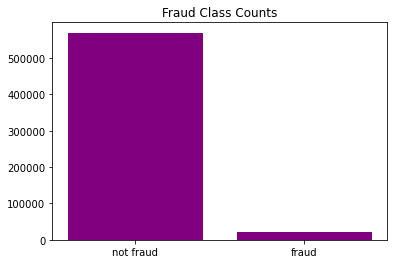

In [6]:
#Fraud Counts
fraud_count = train["isFraud"].value_counts()
plt.figure()
plt.title("Fraud Class Counts")
plt.bar(fraud_count.index,fraud_count.values,color='purple')
plt.xticks([0,1], labels=["not fraud","fraud"])
plt.show()

In [7]:
del train_id
del train_trans

## Preprocess Data

In [8]:
#Remove high missing value columns
columnsToDelete = []
for col in train.columns:
    if(train[col].isnull().sum()/len(train[col]) >= 0.8):
        print(col, "% NaN:", train[col].isnull().sum()/len(train[col]))
        columnsToDelete.append(col)

dist2 % NaN: 0.9362837403054831
D6 % NaN: 0.8760676668811597
D7 % NaN: 0.9340992989467267
D8 % NaN: 0.8731229044603245
D9 % NaN: 0.8731229044603245
D12 % NaN: 0.8904104717715988
D13 % NaN: 0.8950926270870728
D14 % NaN: 0.8946946862193924
V138 % NaN: 0.8612371727571375
V139 % NaN: 0.8612371727571375
V140 % NaN: 0.8612371727571375
V141 % NaN: 0.8612371727571375
V142 % NaN: 0.8612371727571375
V143 % NaN: 0.8612270125647712
V144 % NaN: 0.8612270125647712
V145 % NaN: 0.8612270125647712
V146 % NaN: 0.8612371727571375
V147 % NaN: 0.8612371727571375
V148 % NaN: 0.8612371727571375
V149 % NaN: 0.8612371727571375
V150 % NaN: 0.8612270125647712
V151 % NaN: 0.8612270125647712
V152 % NaN: 0.8612270125647712
V153 % NaN: 0.8612371727571375
V154 % NaN: 0.8612371727571375
V155 % NaN: 0.8612371727571375
V156 % NaN: 0.8612371727571375
V157 % NaN: 0.8612371727571375
V158 % NaN: 0.8612371727571375
V159 % NaN: 0.8612270125647712
V160 % NaN: 0.8612270125647712
V161 % NaN: 0.8612371727571375
V162 % NaN: 0.8612

In [9]:
train = train.drop(columns=columnsToDelete)

In [10]:
v_columns = []
for col in ['V'+str(x) for x in range(1,340)]:
    if col in train.columns:
        v_columns.append(col)

In [11]:
cat_label_features = ["card1","card2","card3","card5", "addr1", "addr2", "id_13","id_17","id_19","id_20","id_31","DeviceInfo"]
num_features = []
cat_onehot_features = ["ProductCD","card4","card6", "M1","M2","M3","M4","M5","M6","M7","M8","M9","id_12","id_15",
                      "id_16","id_28","id_29","id_35","id_36","id_37","id_38","DeviceType","P_emaildomain",
                       "R_emaildomain"]
for col in train.columns:
    if col not in cat_label_features and col not in v_columns and col not in cat_onehot_features:
        num_features.append(col)
num_features.remove('isFraud')
num_features.remove('TransactionID')

print(len(cat_onehot_features))
print(len(cat_label_features))
print(len(num_features))

24
12
30


In [12]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other',
          'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft',
          'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other',
          'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo',
          'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo',
          'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo',
          'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo',
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other',
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple',
          'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other',
          'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

for c in ['P_emaildomain', 'R_emaildomain']:
    train[c] = train[c].map(emails)

In [13]:
train["new_browser"] = np.zeros(train.shape[0])

def setBinaryBrowser(df):
    df.loc[df["id_31"]=="samsung browser 7.0",'new_browser']=1
    df.loc[df["id_31"]=="opera 53.0",'new_browser']=1
    df.loc[df["id_31"]=="mobile safari 10.0",'new_browser']=1
    df.loc[df["id_31"]=="google search application 49.0",'new_browser']=1
    df.loc[df["id_31"]=="firefox 60.0",'new_browser']=1
    df.loc[df["id_31"]=="edge 17.0",'new_browser']=1
    df.loc[df["id_31"]=="chrome 69.0",'new_browser']=1
    df.loc[df["id_31"]=="chrome 67.0 for android",'new_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for android",'new_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for ios",'new_browser']=1
    df.loc[df["id_31"]=="chrome 64.0",'new_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for android",'new_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for ios",'new_browser']=1
    df.loc[df["id_31"]=="chrome 65.0",'new_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for android",'new_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for ios",'new_browser']=1
    df.loc[df["id_31"]=="chrome 66.0",'new_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for android",'new_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for ios",'new_browser']=1
    return df

train = setBinaryBrowser(train)
cat_label_features.remove('id_31')
cat_onehot_features.append('new_browser')
train = train.drop(columns='id_31')

In [14]:
def transform_hour(df, col='TransactionDT'):
    hours = df[col] / (3600)        
    hours = np.floor(hours) % 24
    return hours

train['hours'] = transform_hour(train)
num_features.remove('TransactionDT')
cat_onehot_features.append('hours')

In [15]:
num_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())  
    ]
)

v_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

cat_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder())
    ]
)

preprocessor_c = ColumnTransformer(
    transformers = [
        ('cat', cat_transformer, cat_onehot_features)
    ]
)

preprocessor_v = ColumnTransformer(
    transformers = [
        ('v', v_transformer, v_columns)
    ]
)

preprocessor_num = ColumnTransformer(
    transformers = [
        ('num', num_transformer, num_features)
    ]
)

In [16]:
for col in cat_label_features:
    train[col] = train[col].fillna(train[col].mode()[0])

le = LabelEncoder()
train[cat_label_features] = train[["card1","card2","card3","card5", "addr1", "addr2",
                                   "id_13","id_17","id_19","id_20","DeviceInfo"]].apply(le.fit_transform)

In [17]:
from sklearn.model_selection import train_test_split
y = train.isFraud.values
x_train, x_test, y_train, y_test = train_test_split(train, y, test_size = 0.25, random_state = 5)

In [18]:
x_train_cat_label = x_train[cat_label_features]
x_test_cat_label = x_test[cat_label_features]
mms = MinMaxScaler()
x_train_cat_label = mms.fit_transform(x_train_cat_label)
x_test_cat_label = mms.transform(x_test_cat_label)
print(x_train_cat_label.shape)

(442905, 11)


In [19]:
preprocessor_c.fit(x_train[cat_onehot_features])
x_train_cat_onehot = preprocessor_c.transform(x_train[cat_onehot_features])
x_test_cat_onehot = preprocessor_c.transform(x_test[cat_onehot_features])

In [20]:
x_train_cat_onehot = x_train_cat_onehot.toarray()
x_test_cat_onehot = x_test_cat_onehot.toarray()
print(x_train_cat_onehot.shape)

(442905, 97)


In [21]:
preprocessor_v.fit(x_train[v_columns])
x_train_v = preprocessor_v.transform(x_train[v_columns])
x_test_v = preprocessor_v.transform(x_test[v_columns])
print(x_train_v.shape)

(442905, 292)


In [22]:
#Dimension reduction
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
x_train_v = pca.fit_transform(x_train_v)
x_test_v = pca.transform(x_test_v)
var_explained = pca.explained_variance_ratio_.sum()
print(x_train_v.shape)

(442905, 85)


In [23]:
preprocessor_num.fit(x_train[num_features])
x_train_num = preprocessor_num.transform(x_train[num_features])
x_test_num = preprocessor_num.transform(x_test[num_features])
print(x_train_num.shape)
print(x_test_num.shape)

(442905, 29)
(147635, 29)


In [24]:
x_train_num = x_train_num.astype('float32')
x_test_num = x_test_num.astype('float32')
x_train = np.concatenate((x_train_num, x_train_cat_label, x_train_v, x_train_cat_onehot), axis = 1)
x_test = np.concatenate((x_test_num, x_test_cat_label, x_test_v, x_test_cat_onehot), axis = 1)
print(x_train.shape)
print(x_test.shape)

(442905, 222)
(147635, 222)


In [25]:
smote = SMOTE(sampling_strategy='minority')
x_train, y_train = smote.fit_resample(x_train, y_train)
print(x_train.shape)

(854800, 222)


In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, precision_score, matthews_corrcoef


def print_classification_result(true, predict):
    print(f"Accuracy Score\n: {accuracy_score(true, predict) * 100:.2f}%")
    print(f"Confusion Matrix: \n {confusion_matrix(true, predict)}\n")
    print(f"MCC_Score\n:{matthews_corrcoef(true, predict)}\n")
    print(f"f1_score: \n {f1_score(true, predict)}\n")
    print(f"recall_score: \n {recall_score(true, predict)}\n")
    print(f"Precision_Score\n:{precision_score(true, predict)}")

## Random Forest Classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier
randfclassifier = RandomForestClassifier(n_estimators = 300, criterion = "gini", bootstrap = False)
randfclassifier.fit(x_train, y_train)
y_test_pred_randf = randfclassifier.predict(x_test)
print_classification_result(y_test, y_test_pred_randf)

Accuracy Score
: 98.25%
Confusion Matrix: 
 [[142237    240]
 [  2343   2815]]

MCC_Score
:0.701791108078559

f1_score: 
 0.6854985997808353

recall_score: 
 0.54575416828228

Precision_Score
:0.9214402618657938


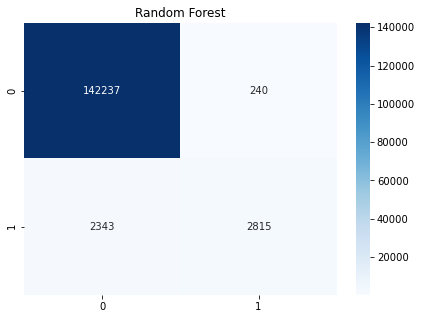

In [28]:
plt.figure(figsize = (7,5))
cm = sb.heatmap(confusion_matrix(y_test, y_test_pred_randf), annot=True, cmap='Blues', fmt='d')
cm.set_title('Random Forest')
plt.show()

## K Nearest Neighbor Classifier

In [29]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5, p = 2, metric = "minkowski")
knn.fit(x_train, y_train)
y_test_pred_KNN = knn.predict(x_test)
print_classification_result(y_test, y_test_pred_KNN)

Accuracy Score
: 90.40%
Confusion Matrix: 
 [[129636  12841]
 [  1328   3830]]

MCC_Score
:0.3785090154706259

f1_score: 
 0.350909340785194

recall_score: 
 0.7425358666149671

Precision_Score
:0.22974026753044208


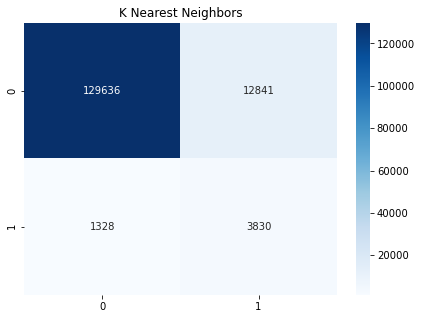

In [30]:
plt.figure(figsize = (7,5))
cm = sb.heatmap(confusion_matrix(y_test, y_test_pred_KNN), annot=True, cmap='Blues', fmt='d')
cm.set_title('K Nearest Neighbors')
plt.show()

## Naive Bayes Classifier

In [31]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train, y_train)
y_test_pred_NB = nb.predict(x_test)
print_classification_result(y_test, y_test_pred_NB)

Accuracy Score
: 81.42%
Confusion Matrix: 
 [[117142  25335]
 [  2094   3064]]

MCC_Score
:0.19389690597394196

f1_score: 
 0.1826146556605179

recall_score: 
 0.5940286932919736

Precision_Score
:0.10789112292686362


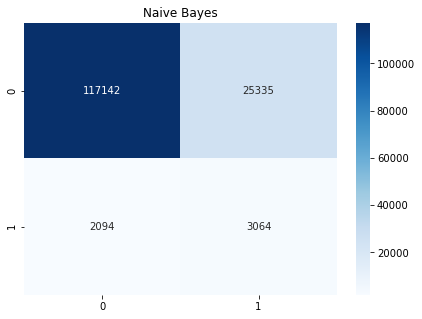

In [32]:
plt.figure(figsize = (7,5))
cm = sb.heatmap(confusion_matrix(y_test, y_test_pred_NB), annot=True, cmap='Blues', fmt='d')
cm.set_title('Naive Bayes')
plt.show()

## Decision Tree Classifier

In [42]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion = "gini", min_samples_leaf = 10)
tree.fit(x_train, y_train)
y_test_pred_tree = tree.predict(x_test)
print_classification_result(y_test, y_test_pred_tree)

Accuracy Score
: 95.50%
Confusion Matrix: 
 [[138201   4276]
 [  2373   2785]]

MCC_Score
:0.4387677342326391

f1_score: 
 0.4558474506915459

recall_score: 
 0.5399379604497867

Precision_Score
:0.39442005381673984


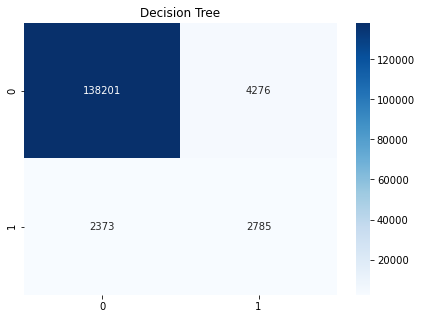

In [43]:
plt.figure(figsize = (7,5))
cm = sb.heatmap(confusion_matrix(y_test, y_test_pred_tree), annot=True, cmap='Blues', fmt='d')
cm.set_title('Decision Tree')
plt.show()

## Logistics Regression

In [29]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(C=1, class_weight= None)
log.fit(x_train, y_train)
y_test_pred_log = log.predict(x_test)
print_classification_result(y_test, y_test_pred_log)

C:\Users\Wilson\Anaconda3\envs\Tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Score
: 81.42%
Confusion Matrix: 
 [[116410  26067]
 [  1361   3797]]

MCC_Score
:0.25286462167338886

f1_score: 
 0.2168351322026155

recall_score: 
 0.7361380379992245

Precision_Score
:0.127143048486472


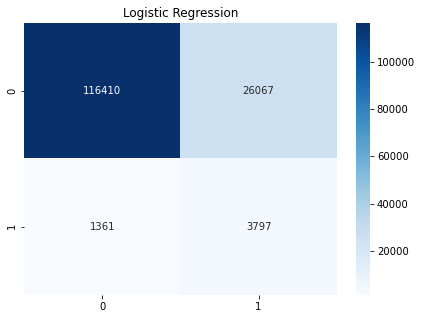

In [30]:
plt.figure(figsize = (7,5))
cm = sb.heatmap(confusion_matrix(y_test, y_test_pred_log), annot=True, cmap='Blues', fmt='d')
cm.set_title('Logistic Regression')
plt.show()

## Artifical Neural Network

In [33]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units = x_train.shape[1] + 1, activation = "relu"))
ann.add(tf.keras.layers.Dense(units = x_train.shape[1]/2, activation = "relu"))
ann.add(tf.keras.layers.Dense(units = 1, activation = "sigmoid"))
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [34]:
loss = ann.fit(x_train, y_train, batch_size = 32, epochs = 20, validation_split = 0.3)

Epoch 1/20
18699/18699 [==============================] - 17s 894us/step - loss: 0.2693 - accuracy: 0.8877 - val_loss: 0.3678 - val_accuracy: 0.8342
Epoch 2/20
18699/18699 [==============================] - 15s 827us/step - loss: 0.1642 - accuracy: 0.9340 - val_loss: 0.2704 - val_accuracy: 0.8854
Epoch 3/20
18699/18699 [==============================] - 15s 794us/step - loss: 0.1254 - accuracy: 0.9508 - val_loss: 0.1841 - val_accuracy: 0.9246
Epoch 4/20
18699/18699 [==============================] - 14s 746us/step - loss: 0.1022 - accuracy: 0.9600 - val_loss: 0.1717 - val_accuracy: 0.9340
Epoch 5/20
18699/18699 [==============================] - 15s 784us/step - loss: 0.0881 - accuracy: 0.9663 - val_loss: 0.0922 - val_accuracy: 0.9653
Epoch 6/20
18699/18699 [==============================] - 15s 792us/step - loss: 0.0778 - accuracy: 0.9704 - val_loss: 0.0975 - val_accuracy: 0.9612
Epoch 7/20
18699/18699 [==============================] - 17s 932us/step - loss: 0.0697 - accuracy: 0.9735

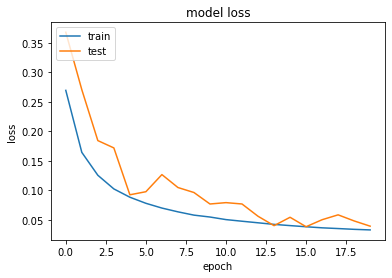

In [35]:
plt.plot(loss.history['loss'])
plt.plot(loss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
y_pred = ann.predict(x_test)
y_pred = np.round(y_pred)
print_classification_result(y_test, y_pred)

Accuracy Score
: 96.92%
Confusion Matrix: 
 [[139992   2485]
 [  2067   3091]]

MCC_Score
:0.5604118780425904

f1_score: 
 0.5759269610583193

recall_score: 
 0.5992632803412176

Precision_Score
:0.5543400286944046


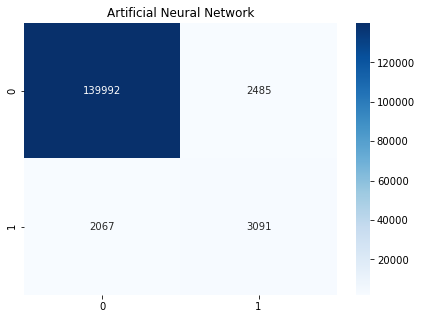

In [37]:
from sklearn.metrics import plot_confusion_matrix
plt.figure(figsize = (7,5))
cm = sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='d')
cm.set_title('Artificial Neural Network')
plt.show()

## Convolutional Neural Network

In [63]:
x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)

In [64]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, activation = 'relu', input_shape = [x_train.shape[1], 1]))
cnn.add(tf.keras.layers.MaxPool1D(pool_size = 2, strides = 1))
cnn.add(tf.keras.layers.Conv1D(filters = 64, kernel_size = 2, activation = 'relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size = 2, strides = 1))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
cnn.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [65]:
loss = cnn.fit(x_train, y_train, batch_size = 32, epochs = 20, verbose = 1, validation_split = 0.3)

Epoch 1/20
18699/18699 [==============================] - 444s 24ms/step - loss: 0.1460 - accuracy: 0.9509 - val_loss: 0.1246 - val_accuracy: 0.9467
Epoch 2/20
18699/18699 [==============================] - 434s 23ms/step - loss: 0.0959 - accuracy: 0.9701 - val_loss: 0.0714 - val_accuracy: 0.9691
Epoch 3/20
18699/18699 [==============================] - 392s 21ms/step - loss: 0.0811 - accuracy: 0.9750 - val_loss: 0.0724 - val_accuracy: 0.9721
Epoch 4/20
18699/18699 [==============================] - 386s 21ms/step - loss: 0.0723 - accuracy: 0.9780 - val_loss: 0.0764 - val_accuracy: 0.9719
Epoch 5/20
18699/18699 [==============================] - 386s 21ms/step - loss: 0.0651 - accuracy: 0.9802 - val_loss: 0.0459 - val_accuracy: 0.9814
Epoch 6/20
18699/18699 [==============================] - 385s 21ms/step - loss: 0.0605 - accuracy: 0.9820 - val_loss: 0.0472 - val_accuracy: 0.9812
Epoch 7/20
18699/18699 [==============================] - 390s 21ms/step - loss: 0.0571 - accuracy: 0.9830

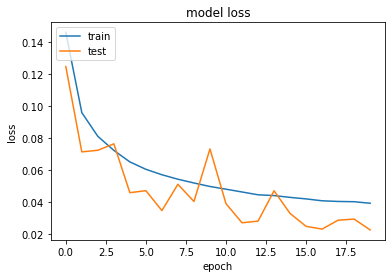

In [66]:
plt.plot(loss.history['loss'])
plt.plot(loss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [67]:
y_pred = cnn.predict(x_test)
y_pred = np.round(y_pred)
print_classification_result(y_test, y_pred)

Accuracy Score
: 97.42%
Confusion Matrix: 
 [[141038   1439]
 [  2365   2793]]

MCC_Score
:0.5847547011860782

f1_score: 
 0.594888178913738

recall_score: 
 0.5414889492051183

Precision_Score
:0.6599716446124764


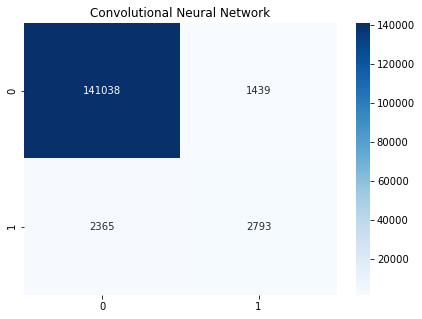

In [68]:
from sklearn.metrics import plot_confusion_matrix
plt.figure(figsize = (7,5))
cm = sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='d')
cm.set_title('Convolutional Neural Network')
plt.show()